In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn

from itertools import islice, count
%matplotlib inline

In [2]:
import pycosmicstar.lcdmcosmology as lcdmcos

lcdmlib not imported, using pure python version of sigma


In [3]:
os.chdir("./optimization-regularization/regularization/")
import regularization as reg

In [4]:
lcdmUniverser = lcdmcos.Lcdmcosmology(omegam=0.24,
                              omegab=0.04, 
                              omegal=0.73,
                               h=0.7)

In [5]:
delta_mbh = 0.1
delta_z = 0.1
dz = -delta_z
dm = delta_mbh
D = dz/dm
m0 = 7.7
mf = 9.6
z0 = 20.0
zf = 0.3

In [6]:
os.chdir("/home/peregrinus/Arquivos/cap/problemas-inversos/projeto")
df = pd.read_csv('mean_LBH.csv')

In [7]:
num_pontos_z = len(df.z.unique())
num_pontos_m = len(df.massBH.unique())

In [8]:
nbh_obs = np.empty((len(df['massBH'].unique()), len(df['z'].unique())))
nbh_obs.fill(np.nan)

In [9]:
for l in range(0, df.shape[0]):
    i = int(np.around(df.z[l]*10.0, decimals=1) - 3.0)
    j = int(np.around(df.massBH[l]*10.0, decimals=1) - 77.0)
    nbh_obs[j][i] = df.nObjects[l]/(delta_mbh*delta_z*(lcdmUniverser.dV_dz(df.zmax[l])-lcdmUniverser.dV_dz(df.z[l])))

In [10]:
class mbh_mean_dt(object):
    def __init__(self, lb_mean_par, mbh_par, alpha_par, tau_par, eta, c = 3e8):
        self.__const1 = (1/c**2.0)*((1-eta)/eta)
        self.__lb_mean_par = lb_mean_par 
        self.__mbh_par = mbh_par 
        self.__alpha_par = alpha_par  
        self.__tau_par = tau_par
        
    def __call__(self, mbh, tz):
        return self.__const1 * self.__lb_mean_par * (mbh/self.__mbh_par)**self.__alpha_par * (self.__tau_par/tz) * np.exp(-tz/self.__tau_par)
    
    @property
    def alpha_par(self):
        return self.__alpha_par

In [11]:
class mbh_mean_dt_dm(object):
    def __init__(self, mbh_mean_dt):
        self.__alpha_par = mbh_mean_dt.alpha_par
        self.__mbh_mean_dt = mbh_mean_dt
    
    def __call__(self, mbh, tz):
        return (self.__alpha_par/mbh) * self.__mbh_mean_dt(mbh, tz)

In [12]:
class V(object):
    def __init__(self, mmt, mmtm):
        self.__mmt = mmt
        self.__mmtm = mmtm

    def __call__(self, mbh, tz, dm):
        return self.__mmtm(mbh, tz) - self.__mmt(mbh, tz)/dm

In [13]:
class V(object):
    def __init__(self, mmt, mmtm):
        self.__mmt = mmt
        self.__mmtm = mmtm

    def __call__(self, mbh, tz, dm):
        return self.__mmtm(mbh, tz) + self.__mmt(mbh, tz)/dm

In [14]:
#        best fit         bias      error 
# lb_mean_par : 3.05e47 : 6.65e45  : 3.14e46
# mbh_par     : 2.19e11 : 1.88e10  : 4.88e10
# alpha_par   : 2.71e-1 : -1.29e-4 : 1.18e-2
# tau_par     : 4.81e9  : 1.05e7   : 1.69e8

mmt = mbh_mean_dt(3.05e7, 2.19e11, 2.71e-1, 4.81e9, 0.5)
mmtm = mbh_mean_dt_dm(mmt)
auxiliarV = V(mmt, mmtm)

In [15]:
# L is a representative function to dt/dz in z = zj
L = lambda z: lcdmUniverser.dt_dz(z)

In [16]:
A = np.identity(num_pontos_m)

# the matriz At for time evolution has dependencie in time, so need to be remake for each time
j = 0
zj = dz*j + z0
tzj = lcdmUniverser.dt_dz(zj)*delta_z

while zj > 0.2:
    At = np.zeros((num_pontos_m, num_pontos_m))
    
    lzj = L(zj)
    for i in islice(count(), 1, num_pontos_m-1):
        mi = dm*i + m0    
        if i-1 >= 0:
            At[i][i-1] = lzj*D*mmt(mi, tzj)
        At[i][i] = 1 - dz*auxiliarV(mi, tzj, dm)*lzj

    mi = dm*0 + m0
    At[0][0] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    mi = dm*(num_pontos_m-1) + m0
    At[num_pontos_m-1][num_pontos_m-1] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    
    A = np.dot(A, At)
    zj += dz
    tzj += lcdmUniverser.dt_dz(zj)*delta_z

In [17]:
# define gaussian function to test
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [18]:
m = np.linspace(m0, mf, num_pontos_m)

In [19]:
# generate initial test condition to evolve in time
test_initial_condition = gaussian(m, (m0+mf)/2., 1.)

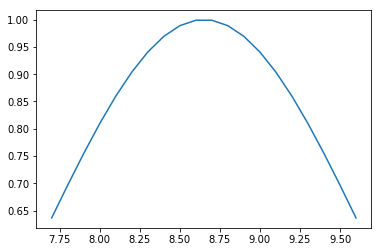

In [20]:
from matplotlib import pyplot as mp
mp.plot(m, test_initial_condition)
mp.show()

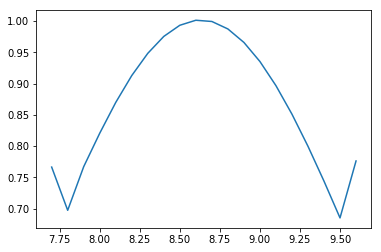

In [21]:
test_initial_condition_evolve = A.dot(test_initial_condition)
mp.plot(m, test_initial_condition_evolve)
mp.show()

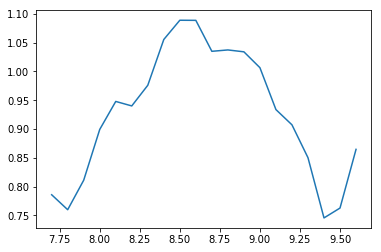

In [22]:
sigma = 0.1
np.random.seed(seed=1234)
test_initial_condition_evolve += sigma*np.random.uniform(low=0.0, high=1.0, size=num_pontos_m)
mp.plot(m, test_initial_condition_evolve)
mp.show()

In [23]:
os.listdir('.')

['duducosmos-pycosmicstar-46caf7b',
 'duducosmos-pycosmicstar-46caf7b.tar.gz',
 'mean_LBH.csv',
 'quasar_data.csv',
 'modelo-direto-apresentacao',
 'apresentcao-primeiros-pontos']

In [24]:
import objectivefunction as ofdd


ImportError: No module named objectivefunction

In [ ]:
alpha = 0.02
tik0 = reg.TikhonovOrder0(num_pontos_m)

J = of.FuncJ(alpha, A.dot, tik0)
Jmeasure = lambda f: J(f, test_initial_condition_evolve)

def evaluate(individual):
    return (Jmeasure(individual),)

In [ ]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

In [ ]:
toolbox = base.Toolbox()

In [ ]:
np.random.seed(1234)
toolbox.register("attr_float", np.random.uniform, 0., 1.)
toolbox.register("individual", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.attr_float,
                 n=num_pontos_m)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=6)

In [ ]:
pop = toolbox.population(n=500)

In [ ]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

#logbook = tools.Logbook()
#logbook.record(gen=0, evals=30, **record)

In [ ]:
result, logbook = algorithms.eaSimple(pop, 
                             toolbox, 
                             cxpb=0.5, 
                             mutpb=0.5, 
                             ngen=200, 
                             stats=stats, verbose=True)

In [ ]:
best = tools.selBest(pop, k=1)[0]
print('Current best fitness:', evaluate(best))

In [ ]:
mp.plot(m, best)
mp.show()